In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import torch
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D
import os
import pickle
import scipy

# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
from neuralplayground.experiments import Sargolini2006Data
from neuralplayground.agents import TrajectoryGenerator, Burak2009, Sorscher2022
from neuralplayground.utils import PlaceCells, get_2d_sort
from neuralplayground.plotting import plot_trajectory_place_cells_activity, plot_ratemaps, compute_ratemaps
from neuralplayground.config import load_plot_config
load_plot_config()

# Show real grid cell + place cell ratemaps from sargolini

In [3]:
sargolini_data = Sargolini2006Data(verbose=True)

Dataset readme:
The sample includes conjunctive cells and head direction cells from layers III and V of medial entorhinal cortex and have  been published in 
Sargolini et al. (Science, 2006). 

The files are in matlab format. They include spike and position times for recorded cells from rats that were running in a 1 x 1 m
enclosure. The cells were recorded in the dorsocaudal 25% portion of the medial entorhinal cortex. Position is given for two LEDs 
to enable calculation of head direction.

The cell id is based on tetrode number and cell number (i.e: t2c7).

The file naming convention is as follow:

Rat number - session number _ cell id (i.e: 11084-03020501_t2c1).

Each session duration is normally 10 minutes, but some sessions are combination of 2 or more 10 minutes sessions, this is marked in 
the file name by using "+" between the session numbers (i.e: 11207-21060501+02_t6c1). Note that the 6 first digits in the session 
number is the date of the recording.

When loading the files 

,rat_id,session,recorded_vars
rec_index,,,
0,11016,02020502,"[T5C1, T7C1, EEG, EGF, position]"
1,11016,25010501,"[T6C2, EEG, EGF, position]"
2,11016,28010501,"[T1C2, EEG, EGF, position]"
3,11016,29010503,"[T5C1, T6C1, T6C2, T7C1, EEG, EGF, position]"
4,11016,31010502,"[T5C2, T6C1, T6C2, T6C3, T8C2, EEG, EGF, posit..."


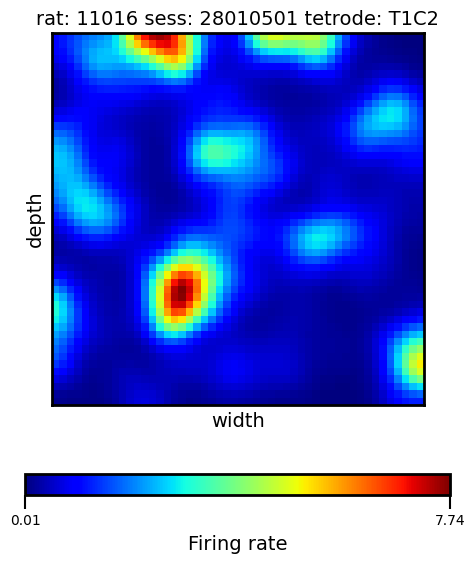

In [4]:
f, ax = plt.subplots(1, 1, figsize=(6, 6))
rate_map, x_bin, y_bin = sargolini_data.plot_recording_tetr(recording_index=2, ax=ax)

# Simulate trajectories and place cell activity
- Refactor the output so it doesn't have the extra dimensions
- Use more sequence steps so you keep track of the cells (batch size of 1)
- Color cell dots by position, then color their activity correspondingly

## Set variables for environment, animal trajectories and place cells

In [5]:
# Arena dimensions  Just 2D
room_width = 2.2
room_depth = 2.2

# We'll use a longer sequence just for plotting purposes
# Training will be done with short sequences
sequence_length = 300
batch_size = 4

# Place cells parameters
n_place_cells = 512
place_cell_rf = 0.12
surround_scale = 2.0
periodic = False
difference_of_gaussians = True

In [6]:
place_cells = PlaceCells(Np=n_place_cells, 
                         place_cell_rf=place_cell_rf,
                         surround_scale=surround_scale, 
                         room_width=room_width, 
                         room_depth=room_depth, 
                         periodic=periodic, 
                         DoG=difference_of_gaussians,
                         device=device)

The following trajectory generator is based on https://github.com/ganguli-lab/grid-pattern-formation/blob/master/trajectory_generator.py which implements https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1002553

In [7]:
generator = TrajectoryGenerator(sequence_length, batch_size, room_width, room_depth, device, place_cells=place_cells)
traj = generator.generate_trajectory(room_width, room_depth, batch_size)
x, y = traj["target_x"], traj["target_y"]

In [8]:
x.shape, y.shape

((4, 300), (4, 300))

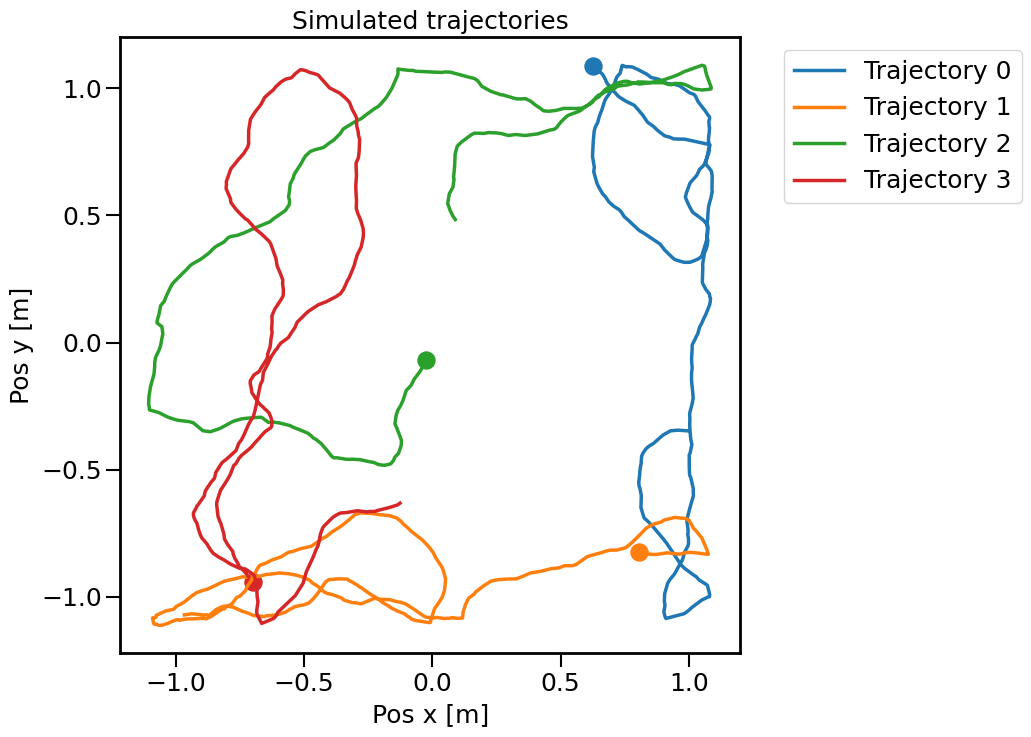

In [9]:
# Plotting options
plot_n_trajectories = batch_size
figure_size = (8, 8)
line_width = 2.5
marker_size = 150

# Plot trajectories
fig, ax = plt.subplots(1, 1, figsize=figure_size)
for i in range(plot_n_trajectories):
    init_x = traj["init_x"][i]
    init_y = traj["init_y"][i]
    ax.plot(x[i, :], y[i, :], label=f"Trajectory {i}", linewidth=line_width)
    ax.scatter(init_x, init_y, color=f"C{i}", marker="o", s=marker_size)
ax.set_xlabel("Pos x [m]")
ax.set_ylabel("Pos y [m]")
ax.set_title("Simulated trajectories")
# Putting the legend outside the plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

In [10]:
# Plot activity for one of the trajectories
trajectory_id = 2
trajectory = np.stack([x[trajectory_id, :], y[trajectory_id, :]], axis=1)

# Get place cell activity for each trajectory
pc_inputs, position, pc_outputs = generator.get_test_batch(traj=traj)
place_cells_positions = place_cells.get_place_cell_positions()
pc_rates_trajectories = pc_outputs[:, trajectory_id, :].detach().cpu().numpy().T

In [11]:
place_cells_positions.shape, pc_rates_trajectories.shape, trajectory.shape

((512, 2), (512, 300), (300, 2))

In [12]:
pc_outputs.shape, position.shape

(torch.Size([300, 4, 512]), torch.Size([300, 4, 2]))

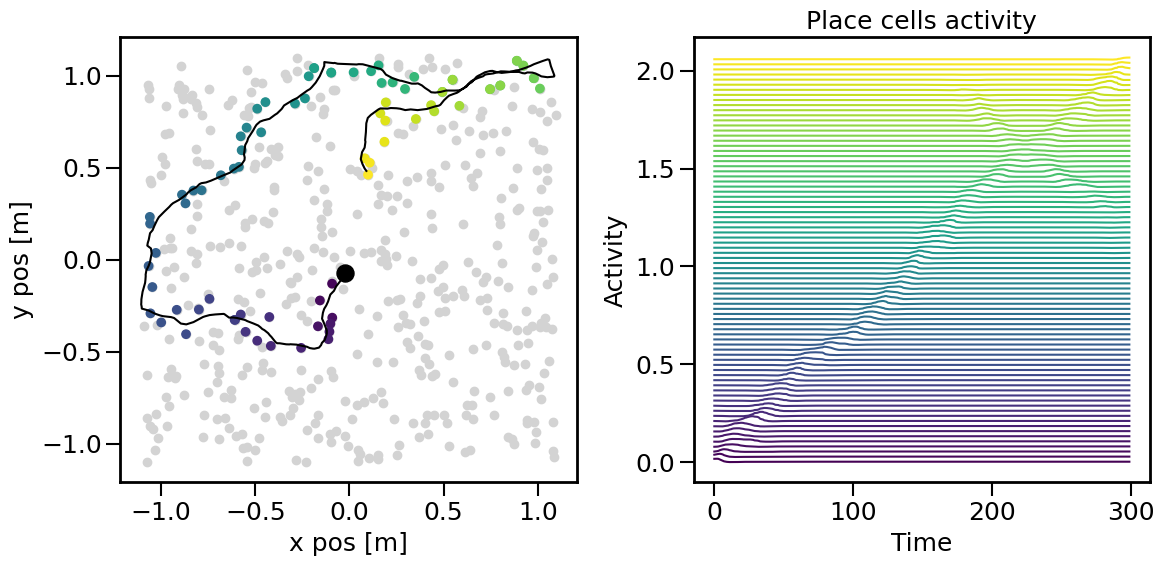

In [13]:
plot_n_cells = 100
raster = True  # Make raster-like plot
log_scale_activity = False

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
ax1, ax2 = plot_trajectory_place_cells_activity(place_cells_center=place_cells_positions, 
                                                place_cell_activity=pc_rates_trajectories, 
                                                trajectory=trajectory, 
                                                ax1=ax1, 
                                                ax2=ax2, 
                                                plot_n_cells=plot_n_cells,
                                                log_scale=log_scale_activity,
                                                raster=raster)
plt.tight_layout()
plt.show()

In [14]:
# Get place cells rate map
pc_outputs_np = pc_outputs.reshape(-1, n_place_cells).detach().cpu().numpy()
pc = place_cells.grid_pc(pc_outputs_np[::100], res=100)

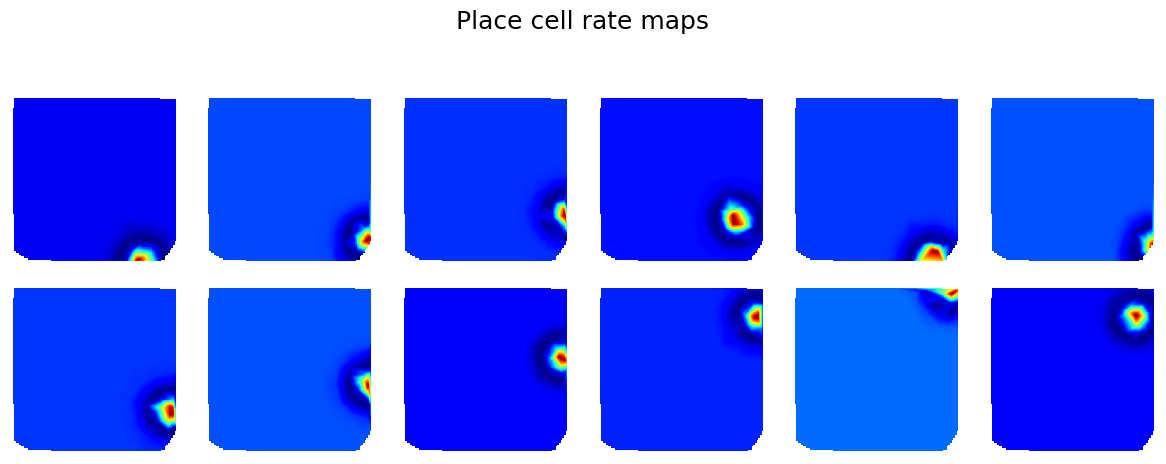

In [15]:
f, ax = plt.subplots(2, 6, figsize=(12, 5))
ax = ax.flatten()
for i in range(12):
    ax[i].imshow(pc[i], cmap="jet")
    ax[i].axis("off")
plt.suptitle("Place cell rate maps")
plt.tight_layout()
plt.show()

In [16]:
# Modified ideal RNN, not from Burak2009 but from Sorscher2022 eq

In [38]:
# TODO: Document Burak 2009
n_grid_cells = 24**2
ideal_RNN = Burak2009(n_neurons=n_grid_cells)
# help(Burak2009)

Building recurrent matrix
debug


In [41]:
iters = 1000
#rates = np.zeros((n_grid_cells, 1))
rates = np.random.normal(size=(n_grid_cells, 1)) *0.01 + 0.01
velocity = np.zeros((2, 1))
# velocity = np.ones((iters, 2, 1))*0.01
#velocity[0] = 1.0
all_updates = []
for i in tqdm(range(iters)):
    rates = ideal_RNN.rate_update(rates, velocity=velocity)
    all_updates.append(rates)
all_updates = np.concatenate(all_updates, axis=1)

  0%|          | 0/1000 [00:00<?, ?it/s]/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/agents/burak2009.py:82: RuntimeWarning: overflow encountered in matmul
  matrix_product = self.Jij @ rates
/home/rodrigo/SSD/Projects/NeuralPlayground/neuralplayground/agents/burak2009.py:82: RuntimeWarning: invalid value encountered in matmul
  matrix_product = self.Jij @ rates
100%|██████████| 1000/1000 [00:01<00:00, 982.10it/s]


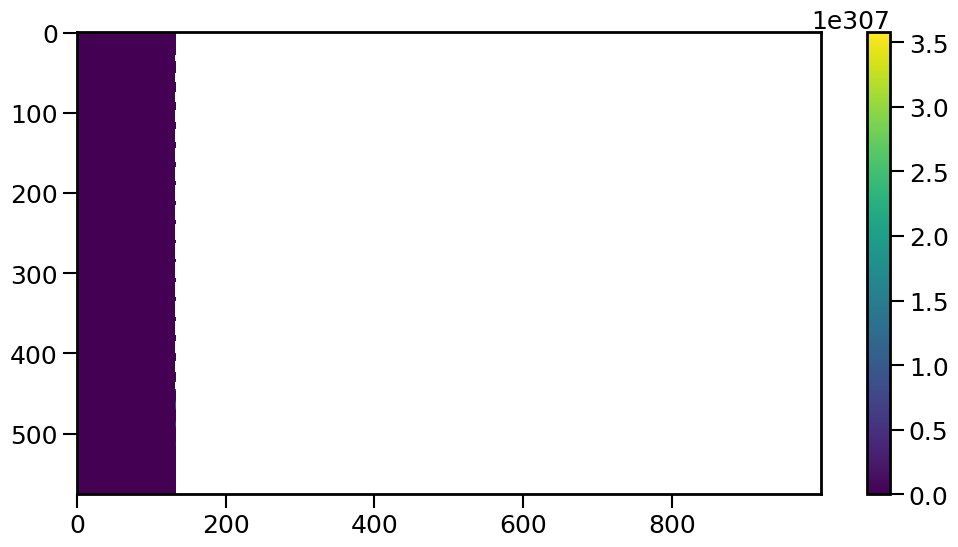

In [42]:
f, ax = plt.subplots(1, 1, figsize=(12, 6))
im = ax.imshow(all_updates, aspect ='auto')
plt.colorbar(im)

In [30]:
# Clock wise velocity vector
iters = 1000
angles = np.linspace(0, 2*np.pi, iters)
#velocity = np.stack([np.cos(angles), np.sin(angles)], axis=1)[..., None]
velocity = np.ones((iters, 2, 1))*0.1
all_updates = []
for i in tqdm(range(iters)):
    rates = ideal_RNN.rate_update(rates, velocity=velocity[i, :])
    all_updates.append(rates)
all_updates = np.concatenate(all_updates, axis=1)

100%|██████████| 1000/1000 [00:00<00:00, 3612.99it/s]


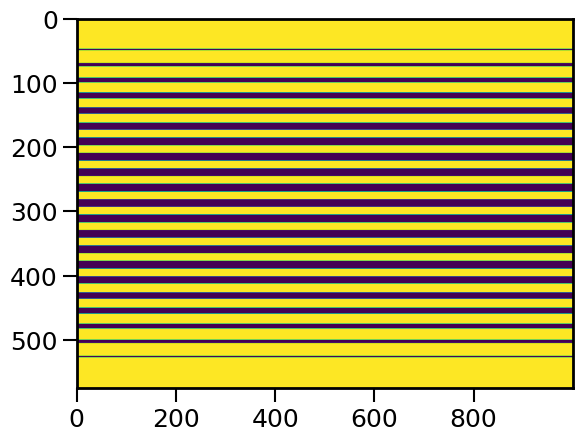

In [31]:
plt.imshow(all_updates, aspect ='auto')

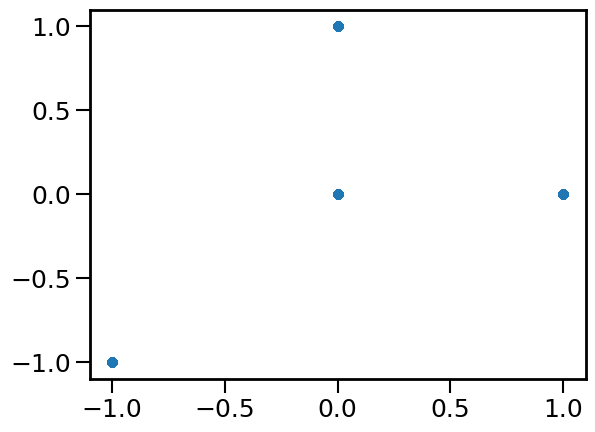

In [22]:
plt.scatter(ideal_RNN.Mixy[:, 0], ideal_RNN.Mixy[:, 1])

In [23]:

ideal_RNN.Mixy.shape

(576, 2)

In [24]:
ideal_RNN.Mixy

array([[-1, -1],
       [ 0,  1],
       [-1, -1],
       ...,
       [ 0,  0],
       [ 1,  0],
       [ 0,  0]])

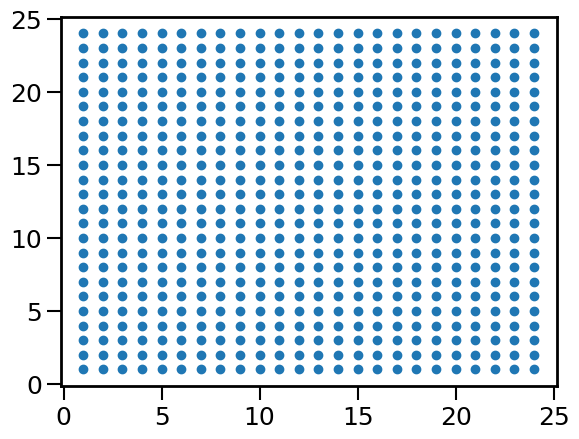

In [25]:
plt.scatter(ideal_RNN.sheet_locations[:, 0], ideal_RNN.sheet_locations[:, 1])

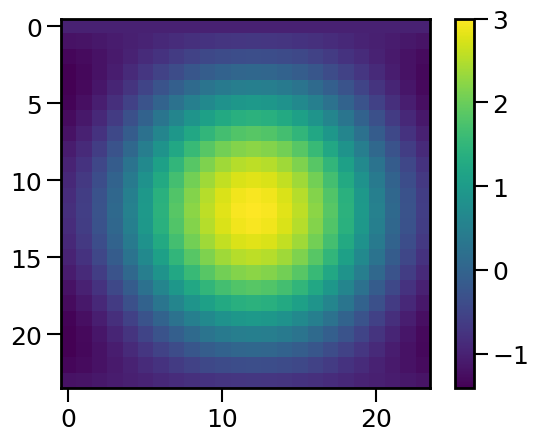

In [26]:
plt.imshow(ideal_RNN.Jij[300, :].reshape(24, 24))
plt.colorbar()

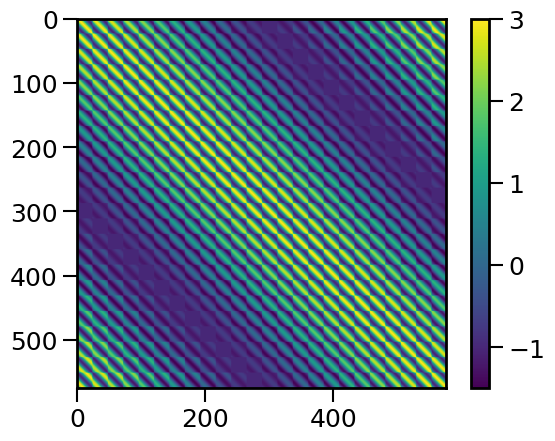

In [27]:
plt.imshow(ideal_RNN.Jij)
plt.colorbar()
plt.show()
# Why getting checkboard pattern in Jij
# 

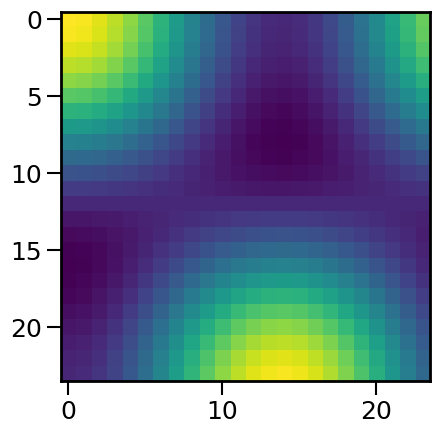

In [28]:
plt.imshow(ideal_RNN.Jij[0, :].reshape(24, 24))